In [ ]:
!pip install optuna
!pip install keras4torch einops
!git clone https://github.com/kailanefelix/stab-redes-neurais.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.5 MB/s eta 0:00:00
Cloning into 'stab-redes-neurais'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 97 (delta 43), reused 20 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (97/97), 62.40 KiB | 4.46 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [ ]:
# Corrigir todos os imports STab -> STAB dentro do repositório
!grep -rl "STab" /content/stab-redes-neurais/STAB | xargs sed -i 's/STab/STAB/g'


In [ ]:
import sys
sys.path.append('/content/stab-redes-neurais')

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from google.colab import drive

from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix,
    precision_recall_fscore_support, accuracy_score
)

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F
import torch.optim as optim

import keras4torch

import STAB
from STAB import mainmodel
from STAB import Num_Cat

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    confusion_matrix
)



In [ ]:
drive.mount('/content/drive')

DATA_DIR = '/content/drive/MyDrive/data_sets_classificacao_churn'

X_train_over = pd.read_csv(f"{DATA_DIR}/X_train_over.csv")
y_train_over = pd.read_csv(f"{DATA_DIR}/y_train_over.csv")

X_val_over = pd.read_csv(f"{DATA_DIR}/X_val_over.csv")
y_val_over = pd.read_csv(f"{DATA_DIR}/y_val_over.csv")

X_test = pd.read_csv(f"{DATA_DIR}/X_test.csv")
y_test = pd.read_csv(f"{DATA_DIR}/y_test.csv")

feature_names = X_train_over.columns.tolist()

Mounted at /content/drive


In [ ]:
def mse_classification_loss(logits, targets, num_classes):
    probs = torch.softmax(logits, dim=1)
    targets_oh = F.one_hot(targets, num_classes=num_classes).float()
    return F.mse_loss(probs, targets_oh)


In [ ]:
scaler = StandardScaler()

X_train_over = scaler.fit_transform(X_train_over).astype(np.float32)
X_val_over   = scaler.transform(X_val_over).astype(np.float32)
X_test       = scaler.transform(X_test).astype(np.float32)

y_train_over = y_train_over.values.astype(int).squeeze()
y_val_over   = y_val_over.values.astype(int).squeeze()
y_test       = y_test.values.astype(int).squeeze()


In [ ]:
def ks_statistic(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return float(np.max(np.abs(tpr - fpr)))


In [ ]:
def build_stab_model(trial, n_features):

    dim = trial.suggest_categorical("dim", [8, 16, 32])
    depth = trial.suggest_int("depth", 1, 3)
    heads = trial.suggest_categorical("heads", [2, 4])

    Or_model = mainmodel.MainModel(
        categories=(),
        num_continuous=n_features,
        dim=dim,
        dim_out=2,
        depth=depth,
        heads=heads,
        attn_dropout=0.1,
        ff_dropout=0.1,
        U=1,
        cases=1,
    )

    model = Num_Cat(
        Or_model,
        num_number=n_features,
        classes=2,
        Sample_size=1
    )

    return keras4torch.Model(model).build([n_features])


In [ ]:
NUM_CLASSES = 2


In [ ]:
def objective(trial):

    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    loss_name = trial.suggest_categorical("loss", ["ce", "mse"])

    model = build_stab_model(trial, X_train_over.shape[1])

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    if loss_name == "ce":
      loss_fn = F.cross_entropy
    else:
      loss_fn = lambda logits, y: mse_classification_loss(
          logits, y, num_classes=NUM_CLASSES
      )

    model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=["accuracy"]
)

    model.fit(
        [X_train_over], y_train_over,
        epochs=20,
        batch_size=128,
        validation_data=([X_val_over], y_val_over),
        verbose=0
    )

    logits = model.predict([X_val_over])
    probs = logits[:, 1]

    ks = ks_statistic(y_val_over, probs)
    return ks


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)


print("Best KS:", study.best_value)
print("Best params:", study.best_params)


[I 2025-12-18 01:03:30,064] A new study created in memory with name: no-name-60ee1301-1e78-4733-ad9f-3c9d815352e1
[I 2025-12-18 01:05:23,341] Trial 0 finished with value: 0.5062111801242235 and parameters: {'lr': 0.00454618212910432, 'weight_decay': 0.000757900423427527, 'loss': 'mse', 'dim': 32, 'depth': 2, 'heads': 2}. Best is trial 0 with value: 0.5062111801242235.
[I 2025-12-18 01:07:05,597] Trial 1 finished with value: 0.5225155279503105 and parameters: {'lr': 0.006532820867393692, 'weight_decay': 8.242948621078675e-05, 'loss': 'mse', 'dim': 16, 'depth': 2, 'heads': 4}. Best is trial 1 with value: 0.5225155279503105.
[I 2025-12-18 01:08:49,319] Trial 2 finished with value: 0.5279503105590062 and parameters: {'lr': 0.0005156513471575085, 'weight_decay': 4.118491130958682e-06, 'loss': 'mse', 'dim': 8, 'depth': 2, 'heads': 2}. Best is trial 2 with value: 0.5279503105590062.
[I 2025-12-18 01:09:46,953] Trial 3 finished with value: 0.5357142857142856 and parameters: {'lr': 0.0080777036

Best KS: 0.5357142857142856
Best params: {'lr': 0.008077703601925055, 'weight_decay': 2.2580860609651903e-05, 'loss': 'ce', 'dim': 16, 'depth': 1, 'heads': 2}


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 128

# Tensores
Xtr = torch.tensor(X_train_over, dtype=torch.float32)
ytr = torch.tensor(y_train_over, dtype=torch.long)

Xva = torch.tensor(X_val_over, dtype=torch.float32)
yva = torch.tensor(y_val_over, dtype=torch.long)

Xte = torch.tensor(X_test, dtype=torch.float32)
yte = torch.tensor(y_test, dtype=torch.long)

# Datasets
train_ds = TensorDataset(Xtr, ytr)
val_ds   = TensorDataset(Xva, yva)
test_ds  = TensorDataset(Xte, yte)

# Loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
best_params = study.best_params

final_model = build_stab_model(
    trial=optuna.trial.FixedTrial(best_params),
    n_features=X_train_over.shape[1]
)

optimizer = torch.optim.AdamW(
    final_model.model.parameters(),
    lr=best_params["lr"],
    weight_decay=best_params["weight_decay"]
)

criterion = torch.nn.CrossEntropyLoss()

final_model.compile(
    optimizer=optimizer,
    loss=criterion,
    metrics=["accuracy"]
)

final_model.fit(
    [X_train_over], y_train_over,
    validation_data=([X_val_over], y_val_over),
    epochs=50,
    batch_size=128,
    verbose=1
)


Train on 5154 samples, validate on 2576 samples:
Epoch 1/50
41/41 - 3.9s - loss: 0.5579 - acc: 0.7220 - val_loss: 0.5194 - val_acc: 0.7461 - lr: 8.1e-03
Epoch 2/50
41/41 - 2.5s - loss: 0.5174 - acc: 0.7441 - val_loss: 0.5153 - val_acc: 0.7488 - lr: 8.1e-03
Epoch 3/50
41/41 - 3.2s - loss: 0.5076 - acc: 0.7559 - val_loss: 0.4989 - val_acc: 0.7613 - lr: 8.1e-03
Epoch 4/50
41/41 - 2.9s - loss: 0.5044 - acc: 0.7573 - val_loss: 0.5065 - val_acc: 0.7484 - lr: 8.1e-03
Epoch 5/50
41/41 - 2.5s - loss: 0.4988 - acc: 0.7518 - val_loss: 0.5028 - val_acc: 0.7593 - lr: 8.1e-03
Epoch 6/50
41/41 - 2.5s - loss: 0.5050 - acc: 0.7511 - val_loss: 0.5216 - val_acc: 0.7426 - lr: 8.1e-03
Epoch 7/50
41/41 - 2.6s - loss: 0.4930 - acc: 0.7575 - val_loss: 0.5177 - val_acc: 0.7550 - lr: 8.1e-03
Epoch 8/50
41/41 - 3.6s - loss: 0.4925 - acc: 0.7549 - val_loss: 0.4999 - val_acc: 0.7628 - lr: 8.1e-03
Epoch 9/50
41/41 - 2.6s - loss: 0.4930 - acc: 0.7540 - val_loss: 0.5042 - val_acc: 0.7624 - lr: 8.1e-03
Epoch 10/50
41/

,loss,acc,val_loss,val_acc,lr
1,0.557936,0.721964,0.519379,0.746118,0.008078
2,0.517381,0.744082,0.515314,0.748835,0.008078
3,0.507561,0.755918,0.498935,0.761258,0.008078
4,0.504406,0.757276,0.506503,0.748447,0.008078
5,0.498824,0.751843,0.502766,0.759317,0.008078
6,0.504955,0.751067,0.521645,0.742624,0.008078
7,0.492994,0.757470,0.517729,0.755047,0.008078
8,0.492451,0.754948,0.499886,0.762811,0.008078
9,0.493044,0.753977,0.504174,0.762422,0.008078
10,0.493323,0.754172,0.538226,0.743401,0.008078


In [ ]:
def predict_proba(model, X, y):
    model.model.eval()

    device = next(model.model.parameters()).device

    X = torch.tensor(X, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.long).to(device)

    with torch.no_grad():
        logits = model.model(X)
        probs = torch.softmax(logits, dim=1)[:, 1]

    return probs.cpu().numpy(), y.cpu().numpy()


In [ ]:
p_train, y_train_true = predict_proba(final_model, X_train_over, y_train_over)
p_val,   y_val_true   = predict_proba(final_model, X_val_over, y_val_over)
p_test,  y_test_true  = predict_proba(final_model, X_test, y_test)


In [ ]:
from scipy.stats import ks_2samp

def ks_score(y_true, y_prob):
    return ks_2samp(
        y_prob[y_true == 1],
        y_prob[y_true == 0]
    ).statistic


In [ ]:
print(f"KS Train: {ks_score(y_train_true, p_train):.4f}")
print(f"KS Val  : {ks_score(y_val_true, p_val):.4f}")
print(f"KS Test : {ks_score(y_test_true, p_test):.4f}")


KS Train: 0.6151
KS Val  : 0.4915
KS Test : 0.5264


In [ ]:
from sklearn.metrics import roc_auc_score

print(f"AUC Train: {roc_auc_score(y_train_true, p_train):.4f}")
print(f"AUC Val  : {roc_auc_score(y_val_true, p_val):.4f}")
print(f"AUC Test : {roc_auc_score(y_test_true, p_test):.4f}")


AUC Train: 0.8890
AUC Val  : 0.8135
AUC Test : 0.8310


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = (p_test >= 0.5).astype(int)

print(confusion_matrix(y_test_true, y_pred))
print(classification_report(y_test_true, y_pred))


[[911 377]
 [ 86 379]]
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1288
           1       0.50      0.82      0.62       465

    accuracy                           0.74      1753
   macro avg       0.71      0.76      0.71      1753
weighted avg       0.80      0.74      0.75      1753



In [ ]:
from sklearn.metrics import mean_squared_error, log_loss

print("MSE:")
print("Train:", mean_squared_error(y_train_true, p_train))
print("Val  :", mean_squared_error(y_val_true, p_val))
print("Test :", mean_squared_error(y_test_true, p_test))

print("\nCross-Entropy:")
print("Train:", log_loss(y_train_true, p_train))
print("Val  :", log_loss(y_val_true, p_val))
print("Test :", log_loss(y_test_true, p_test))


MSE:
Train: 0.1356627643108368
Val  : 0.1783374696969986
Test : 0.17594081163406372

Cross-Entropy:
Train: 0.416683736386196
Val  : 0.553277136966429
Test : 0.5273610039980363


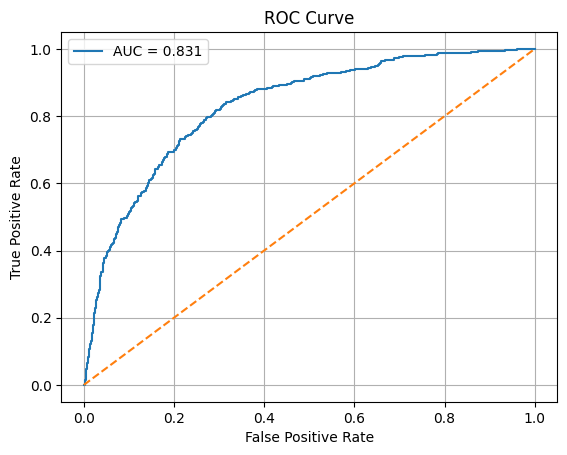

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_true, p_test)
auc_score = roc_auc_score(y_test_true, p_test)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


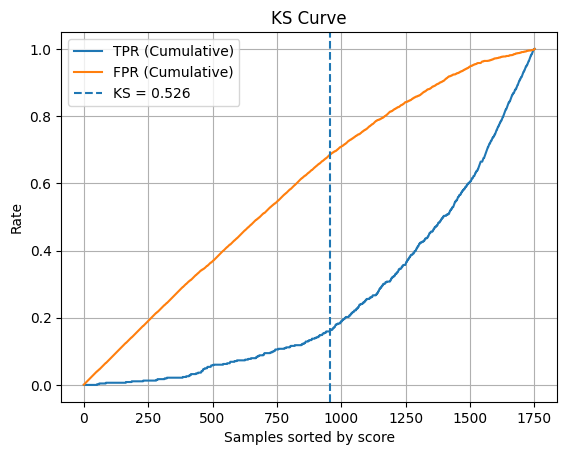

In [ ]:
# Ordena pelo score
order = np.argsort(p_test)
y_sorted = y_test_true[order]

# Cálculo acumulado
cum_pos = np.cumsum(y_sorted) / np.sum(y_sorted)
cum_neg = np.cumsum(1 - y_sorted) / np.sum(1 - y_sorted)

ks_stat = np.max(np.abs(cum_pos - cum_neg))
ks_idx = np.argmax(np.abs(cum_pos - cum_neg))

plt.figure()
plt.plot(cum_pos, label="TPR (Cumulative)")
plt.plot(cum_neg, label="FPR (Cumulative)")
plt.axvline(ks_idx, linestyle="--", label=f"KS = {ks_stat:.3f}")
plt.xlabel("Samples sorted by score")
plt.ylabel("Rate")
plt.title("KS Curve")
plt.legend()
plt.grid(True)
plt.show()


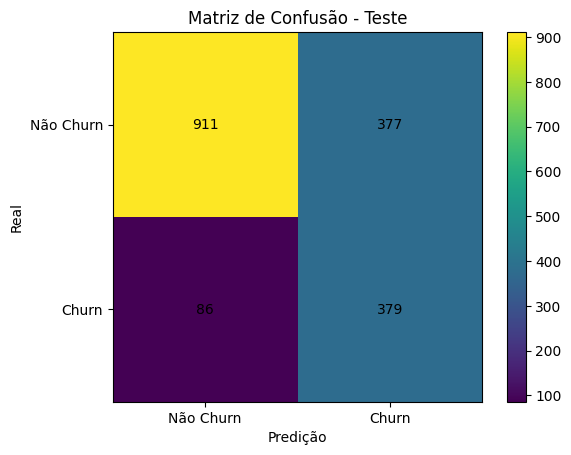

In [ ]:
threshold = 0.5
y_pred = (p_test >= threshold).astype(int)

cm = confusion_matrix(y_test_true, y_pred)

plt.figure()
plt.imshow(cm)
plt.colorbar()
plt.xticks([0, 1], ["Não Churn", "Churn"])
plt.yticks([0, 1], ["Não Churn", "Churn"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predição")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Teste")
plt.show()
